<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex02/luiz_gontijo/Notebook_Aula02_Luiz_Fernando_Gontijo_Using_BCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook de referência 

Nome: Luiz Fernando da Costa Gontijo RA230677

## Instruções

Este exercício consiste em escrever um código para treinar um modelo linear usando SGD e vizualizar como a função de perda varia em função das pesos da rede.

Para a realização da tarefa informada em sala, foram retirados os asserts postos anteriormente. 

As atualizações para este notebook foram:

1- Aplicar função de loss Binary Cross Entropy (BCE) no lugar da MSE. A função BCE foi disponibilizada pelo professor;

2- Aplicar a função sigmoid na etapa de treino e de levantamento do grid de valores. Essa função não era necessária para o caso anterior;

3- Aplicar a função BCE para levantamento do grid de valores ao final do notebook;

4- Foi necessário o aumento da quantidade de épocas para o treinamento;

5- Foi necessário o aumento da taxa de aprendizado (learning_rate) para que os resultados pudessem convergir de forma mais rápida.

# Problemas na utilização da função BCE como função de custo

O resultado apresentado ao final do notebook permitiu confirmar que o algoritmo convergiu para o valore esperado. Entretanto, a função de erro permanece fornecendo valores em torno de 0.600. Esse fato faz com que o grid de valores, os quais fornecem o plano, não tenha a imagem esperada. Além disso, os resultados dados pela função convergem para o mínimo indicado, porém, o valor apresentado como ideal foi deslocado para um ponto fora do mínimo. A atualização do valor ideal deve ser feita para melhor visualizar o resultado. 

## Problema de Regressão Linear

O problema de ajuste de uma reta a um conjunto de pontos para verificar se existe uma previsão linear é um problema muito antigo, muito estudado e muito presente nos dias de hoje. 

Quando o ajuste é abordado como um problema de **otimização numérica**, ele é a base de boa parte dos **conceitos sobre redes neurais** e iremos explorá-lo aqui como uma forma de introdução às redes neurais. O modelo de regressão linear que iremos utilizar pode
ser visto como uma rede neural de apenas uma camada e função de ativação linear.

## Conjunto de dados: Flores Íris

Iremos utilizar duas propriedades do conjunto de dados das flores Íris [Wikipedia-Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set):

* o comprimento das sépalas e 
* o comprimento da pétalas. 

A ideia será prever o comprimento da pétala, conhecendo-se o comprimento da sépala. Estaremos usando apenas uma propriedade, ou característica ou *feature* do objeto para que seja fácil visualizar o espaço de busca de parâmetros. 

Vamos utilizar as 50 amostras da variedade versicolor.

![](https://raw.githubusercontent.com/robertoalotufo/files/master/figures/iris_petals_sepals.png)

## Dados: leitura e visualização


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython import display

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import time

In [3]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_in = data[:,0:1]
y_in = data[:,1:2]
iris_pd = pd.DataFrame(x_in, columns=['x_in'])
iris_pd['y_in'] = y_in
iris_pd.head()

,x_in,y_in
0,7.0,4.7
1,6.4,4.5
2,6.9,4.9
3,5.5,4.0
4,6.5,4.6


## Visualização dos dados `x_in` e `y_in` e normalizados

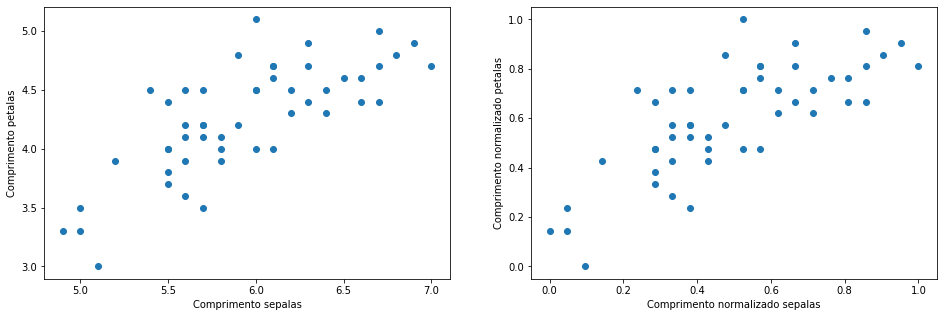

In [4]:
x = x_in - x_in.min()
x /= x.max()    # normalização
y = y_in - y_in.min()
y /= y.max()

fig = plt.figure(figsize=(16,5))
ax_in = fig.add_subplot(1,2,1)
ax_in.scatter(x_in, y_in)
ax_in.set_xlabel('Comprimento sepalas')
ax_in.set_ylabel('Comprimento petalas')
ax_n = fig.add_subplot(1,2,2)
ax_n.scatter(x, y)
ax_n.set_xlabel('Comprimento normalizado sepalas')
ax_n.set_ylabel('Comprimento normalizado petalas');

## Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:


<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/linhareta.png" width="300pt">

A reta de ajuste será dada por:

$$ \hat{y} = w_0 + w_1 x $$

onde 
* $w_1$ é o coeficiente angular da reta e 
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e 
* $\hat{y}$ é a predição (comprimento estimado das pétalas).

## Representação gráfica da equação linear via neurônio

$ \hat{y} = 1 w_0 + x_0 w_1 $

Temos:
- 1 atributo de entrada: $x_0$
- 2 parâmetros para serem ajustados (treinados) $w_0$ e $w_1$
- 1 classe de saída $\hat{y}$

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinearNeuronio.png" width="300pt">
$$ \hat{y} = w_0 + w_1 x $$
$$ \mathbf{\hat{y}} = \mathbf{w} \mathbf{x} $$

### Função Custo ou de Perda (MSE - Mean Square Error)

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master//figures/Loss_MSE.png" width = "600pt">


A função de custo depende do conjunto de treinamento ($y_i$) e dos valores de predição ($\hat{y_i}$):

$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$ .


## Laço de minimização via gradiente descendente

O código da próxima célula é a parte principal deste notebook. É aqui que a minimização é feita. É aqui que dizemos que estamos fazendo o *fit*, ou o treinamento do sistema para encontrar o parâmetro $\mathbf{W}$ que minimiza a função de perda $J$. Acompanhamos a convergência da minimização pelo valor da perda a cada iteração, plotando o vetor `J_history`.

O esquema da otimização é representado pelo diagrama a seguir:

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinear_Otimizacao.png" width = "600pt">

e é implementado pela próxima célula de código:

## Funções: Custo, Gradiente Descendente

In [5]:
# É importante fixar as seeds para passar nos asserts abaixo.

import random
import numpy as np

random.seed(123)
np.random.seed(123)

In [6]:
class Model():
    def __init__(self, n_in: int, n_out: int):
        # Escreva seu código aqui.
        # Não se esqueça de inicializar os pesos da rede com zeros.
        self.w = np.zeros((n_out,n_in))
    
    def forward(self, x):
        # Escreva seu código aqui.
        # equação: y_pred = w.Tx -> produto escalar entre matriz de pesos w e vetor de entrada x
        y_pred = x.dot(self.w.T)
        return y_pred

In [7]:
def BCE(y,y_hat):
    return -((y * np.log(y_hat))+((1-y) * np.log(1-y_hat)))

In [119]:
def train(model, x, y, learning_rate: float, n_epochs: int):
    """Train a linear model with SGD.

    Returns:
        loss_history: a np.array of shape (n_epochs,)
        w_history: a np.array of shape (n_epochs, 2)
    """
    # Escreva seu código aqui.
    loss_history = [] # guardar valores de loss do loop
    w_history = [] # guardar valores de w do loop

    n_samples = np.size(x)

    x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x])

    for epoch in range(n_epochs + 1):

      # forward - predict
      y_pred = model.forward(x_train_bias)

      # sigmoid
      z = np.exp(-y_pred)
      y_hat = 1 / (1 + z)

      loss_total = BCE(y, y_hat)
      loss = loss_total.mean()
      loss_history.append(loss)

      # gradiente - utilizar derivadas parciais do vetor J - atualizar para o caso BCE
      w_grad = (1.0/n_samples) * (x_train_bias.T).dot(y_hat - y)

      # salvar valores de w
      w_history = np.append(w_history, model.w)

      # gradient descent - atualizar os pesos
      model.w = model.w - learning_rate * w_grad.T
      print('Epoch[{}/{}], loss: {:.6f}'.format(epoch, n_epochs, loss))

    w_history = w_history.reshape((int(np.size(w_history)/2), 2))
    return loss_history, w_history

### Testando as funções

In [138]:
model = Model(2, 1) # duas entradas (1 + x0) e uma saída y_pred
loss_history, w_history = train(model=model, x=x, y=y, learning_rate=0.5, n_epochs=300)

Epoch[0/300], loss: 0.693147
Epoch[1/300], loss: 0.684766
Epoch[2/300], loss: 0.678647
Epoch[3/300], loss: 0.674135
Epoch[4/300], loss: 0.670763
Epoch[5/300], loss: 0.668203
Epoch[6/300], loss: 0.666222
Epoch[7/300], loss: 0.664653
Epoch[8/300], loss: 0.663382
Epoch[9/300], loss: 0.662324
Epoch[10/300], loss: 0.661420
Epoch[11/300], loss: 0.660630
Epoch[12/300], loss: 0.659921
Epoch[13/300], loss: 0.659274
Epoch[14/300], loss: 0.658671
Epoch[15/300], loss: 0.658103
Epoch[16/300], loss: 0.657561
Epoch[17/300], loss: 0.657039
Epoch[18/300], loss: 0.656534
Epoch[19/300], loss: 0.656041
Epoch[20/300], loss: 0.655560
Epoch[21/300], loss: 0.655087
Epoch[22/300], loss: 0.654623
Epoch[23/300], loss: 0.654166
Epoch[24/300], loss: 0.653716
Epoch[25/300], loss: 0.653271
Epoch[26/300], loss: 0.652832
Epoch[27/300], loss: 0.652399
Epoch[28/300], loss: 0.651971
Epoch[29/300], loss: 0.651548
Epoch[30/300], loss: 0.651130
Epoch[31/300], loss: 0.650716
Epoch[32/300], loss: 0.650307
Epoch[33/300], loss:

# Função de cálculo do grid de custos

In [139]:
def compute_loss_grid(x, y, w_0_grid, w_1_grid):
    """Returns:
        loss_grid: an array with the same shape (w_0_grid.shape[0], w_1_grid.shape[0])
    """
    # Escreva seu código aqui.

    # meshgrid dos pesos do bias (w0) e da variável (w1) 
    ww0, ww1 = np.meshgrid(w_0_grid, w_1_grid)
    w_grid = np.c_[ww0.ravel(), ww1.ravel()] # combinação de todos os pesos possíveis w0 e w1

    # computar a loss para cada valor do w_grid
    n_samples = np.size(x)
    x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x])

    y_pred = x_train_bias.dot(w_grid.T)

    y_pred = 1/(1 + np.exp(-y_pred))

    errors = y_pred - y

    errors_bce = BCE(y,y_pred).mean(axis=0) # calcular o BCE

    loss_grid = errors_bce.reshape((w_0_grid.shape[0], w_1_grid.shape[0]))

    return loss_grid

In [140]:
wmin = w_history.min(axis=0)
wmax = w_history.max(axis=0)
D = wmax - wmin
wmin -= D
wmax += D

w_0_grid = np.linspace(wmin[0], wmax[0], 100)
w_1_grid = np.linspace(wmin[1], wmax[1], 100)

loss_grid = compute_loss_grid(x, y, w_0_grid, w_1_grid)

### Testando a função

In [141]:
!gsutil cp gs://unicamp-dl/ia025a_2022s1/aula2/target_loss_grid.npy .
target_loss_grid = np.load('target_loss_grid.npy')

Copying gs://unicamp-dl/ia025a_2022s1/aula2/target_loss_grid.npy...
/ [1 files][ 78.2 KiB/ 78.2 KiB]                                                
Operation completed over 1 objects/78.2 KiB.                                     


## Funcão de Plot

In [142]:
def show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.3):
    n_samples = y.shape[0]

    # valor ótimo, solução analítica
    # ------------------------------
    x_bias = np.hstack([np.ones((n_samples, 1)), x])
    w_opt = (np.linalg.inv((x_bias.T).dot(x_bias)).dot(x_bias.T)).dot(y)    
    x_all = np.linspace(x.min(), x.max(), 100).reshape(100, 1)
    x_all_bias = np.hstack([np.ones((100, 1)), x_all])
    result_opt = x_all_bias.dot(w_opt)    # Predição do valor ótimo
        
    # Gráficos:
    # --------
    fig = plt.figure(figsize=(18, 6))
    ax_grid = fig.add_subplot(1, 3, 1)    # Grid de losses
    ax_loss = fig.add_subplot(1, 3, 2)    # Função perda

    ax_loss.plot(loss_history)
    ax_loss.set_title('Perda', fontsize=15)
    ax_loss.set_xlabel('epochs', fontsize=10)
    ax_loss.set_ylabel('MSE', fontsize=10)

    ax_grid.pcolormesh(w_0_grid, w_1_grid, loss_grid, cmap=plt.cm.coolwarm)
    ax_grid.contour(w_0_grid, w_1_grid, loss_grid, 20)
    ax_grid.scatter(w_opt[0], w_opt[1], marker='x', c='w')  # Solução analítica.
    ax_grid.set_title('W', fontsize=15)
    ax_grid.set_xlabel('w0', fontsize=10)
    ax_grid.set_ylabel('w1', fontsize=10)

    # Plot dinâmico
    # -------------
    for i, (loss, w) in enumerate(zip(loss_history, w_history)):
        ax_loss.scatter(i, loss)
                            
        ax_grid.scatter(w[0], w[1], c='r', marker='o')
        
        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(sleep)


## Plotagem iterativa do gradiente descendente, reta ajuste, parâmetros, função perda

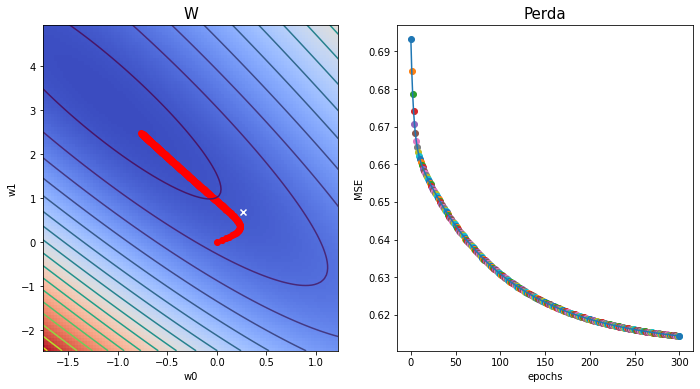

In [143]:
%matplotlib inline
try:
    show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.01)
except KeyboardInterrupt:
    pass